# Gaussian Process Regression for Thermal Soaring

Rather than learning the parameters for a Gaussian-shaped thermal, learn the function with Gaussian process regression.

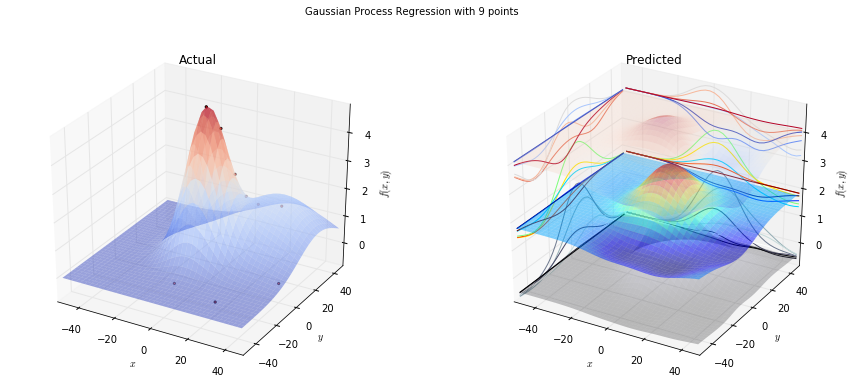

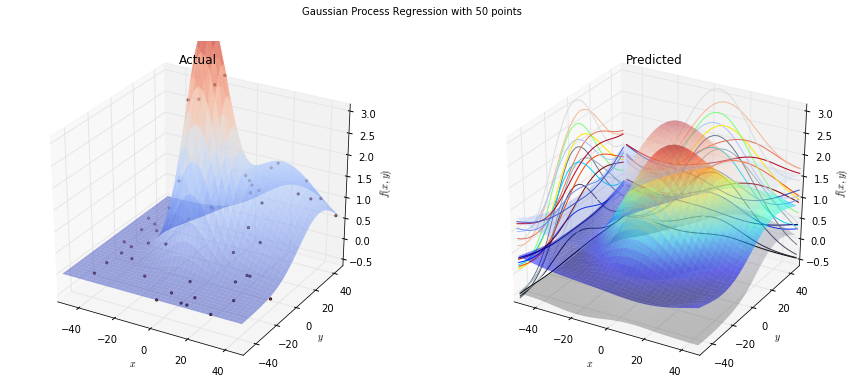

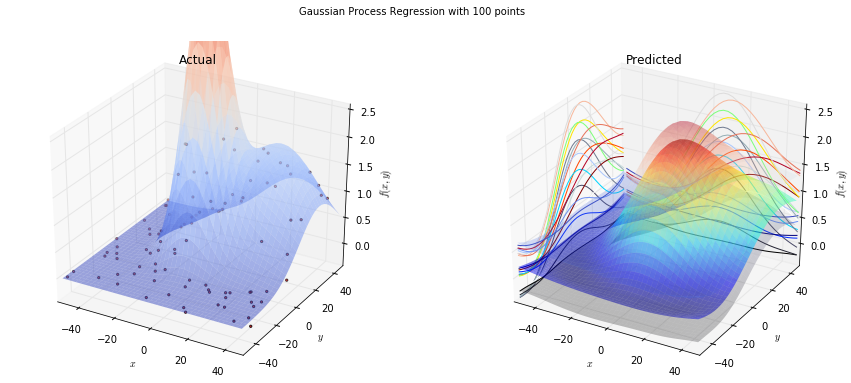

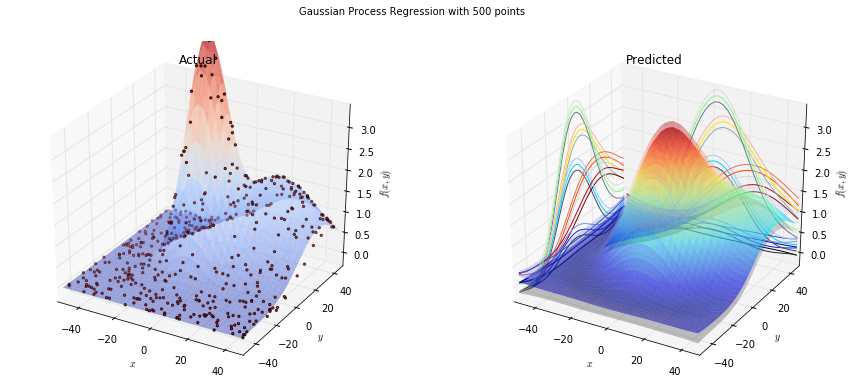

In [24]:
# For calculation
import sys
import random
import numpy as np
import pymc3 as pm
import scipy as sp
import theano
import theano.tensor as t
from collections import Counter
from sklearn.gaussian_process import GaussianProcess

# For visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.path import Path
from matplotlib.collections import PatchCollection
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D

# Display plots in Jupyter
%matplotlib inline

# For reproducibility
random.seed(126)
np.random.seed(123)

# Vertical velocity as function of the thermal's position and width
def deterministicVelocity(path, measurements, thermal_position,
                          thermal_amplitude, thermal_sd):
    # Fix "Cannot compute test value" error, see: http://stackoverflow.com/a/30241668
    #theano.config.compute_test_value = 'ignore'
    
    # Create the function but already plug in some values we want to test with
    # See: https://www.quora.com/What-is-the-meaning-and-benefit-of-shared-variables-in-Theano
    x = theano.shared(np.array([x for x,y in path]))
    y = theano.shared(np.array([y for x,y in path]))
    
    # These functions now refer to the shared variables
    # Do not compile here, see: http://stackoverflow.com/q/30426216
    def gaussianTheano(xo, yo, amplitude, sigma_x, sigma_y):
        #xo = float(xo)
        #yo = float(yo)
        theta = offset = 0 # for now
        a = (pm.cos(theta)**2)/(2*sigma_x**2) + (pm.sin(theta)**2)/(2*sigma_y**2)
        b = -(pm.sin(2*theta))/(4*sigma_x**2) + (pm.sin(2*theta))/(4*sigma_y**2)
        c = (pm.sin(theta)**2)/(2*sigma_x**2) + (pm.cos(theta)**2)/(2*sigma_y**2)
        gauss = offset+amplitude*pm.exp(-1*(a*((x-xo)**2)+2*b*(x-xo)*(y-yo)+c*((y-yo)**2)))
        return gauss
    
    # Return the Theano function that we'll use when sampling
    return gaussianTheano(thermal_position[0], thermal_position[1],
                          thermal_amplitude, thermal_sd, thermal_sd)

# Zero offset, rotation, and same sigma in both x and y
def thermalEq(position, amplitude, sd):
    return gaussian(position[0], position[1], amplitude, sd, sd, 0, 0)

# See: http://stackoverflow.com/q/25342899
def gaussian(xo, yo, amplitude, sigma_x, sigma_y, theta, offset):
    xo = float(xo)
    yo = float(yo)
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    gauss = lambda x,y: offset+amplitude*np.exp(-1*(a*((x-xo)**2)+2*b*(x-xo)*(y-yo)+c*((y-yo)**2)))
    return gauss

# Take single measurement
def takeMeasurement(field, position):
    measurement = 0

    for thermal in field:
        measurement += thermal(position[0], position[1])

    return measurement

# Take measurements at the points along the path
# Input: field=[eq1, eq2, ...], path=[(x1,y1),(x2,y2),...]
# Output: [v1, v2, ...]
def takeMeasurements(field, path):
    measurements = np.empty(len(path))
    
    for i, pos in enumerate(path):
        measurements[i] = takeMeasurement(field, pos)
    
    return measurements

#
# Create the visualization of the 3D thermal field, our path,
# and where we think the thermals are
#
def visualizeThermalField(field, path, trace, pos_min, pos_max,
                          legend=False, only2d=False, center=None):
    fig = plt.figure(figsize=(15,8))
    
    if only2d:
        ax = fig.add_subplot(111)
    else:
        ax = fig.add_subplot(111, projection='3d')
        
    plt.title('Gaussian Thermal Field')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    
    if not only2d:
        ax.set_zlabel('Vertical Velocity')
    
    # The learned values, first so they're displayed on the bottom
    plt.scatter(trace["thermal_position"][:,0], trace["thermal_position"][:,1],
                alpha=0.05, c="r")
    
    # Evaluate thermal field equations over X,Y
    # See: http://matplotlib.org/examples/mplot3d/surface3d_demo.html
    X = np.arange(pos_min, pos_max, (pos_max-pos_min)/40)
    Y = np.arange(pos_min, pos_max, (pos_max-pos_min)/40)
    X, Y = np.meshgrid(X, Y)
    Z = np.zeros((len(X),len(Y)))

    for thermal in field:
        Z += thermal(X, Y)

    if not only2d:
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                           alpha=0.5, linewidth=0, antialiased=True)

        fig.colorbar(surf, aspect=10, shrink=0.3)

    # Contours so we can see how it compares with the path
    # See: http://matplotlib.org/examples/mplot3d/contour3d_demo3.html
    cset = ax.contour(X, Y, Z, zdir='z', offset=0, cmap=cm.coolwarm)
    #cset = ax.contour(X, Y, Z, zdir='x', offset=pos_min, cmap=cm.coolwarm)
    #cset = ax.contour(X, Y, Z, zdir='y', offset=pos_max, cmap=cm.coolwarm)
    
    # Plot the path
    # See: http://matplotlib.org/examples/mplot3d/lines3d_demo.html
    #ax.plot(X, Y, Z)
    
    # Plot the path as line segments
    # See: http://stackoverflow.com/a/11541628
    for i in range(1, len(path)):
        if only2d:
            ax.plot([path[i-1][0], path[i][0]], [path[i-1][1],path[i][1]],
                label='Path Segment #'+str(i))
        else:
            ax.plot([path[i-1][0], path[i][0]], [path[i-1][1],path[i][1]],
                    zs=[0,0], label='Path Segment #'+str(i))
    
    # Put legend outside the graph
    # See: http://stackoverflow.com/a/4701285
    if legend:
        # Shrink current axis by 20%
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Display where we think the center is
    if center:
        ax.plot([center[0]], [center[1]], 'sb', markersize=10)
        # From: http://stackoverflow.com/a/5147430
        #plt.annotate("Center", xy=center, xytext=(-20, 20),
        #             textcoords='offset points', ha='right', va='bottom',
        #             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        #             arrowprops=dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

#
# Use PyMC3 to determine the posterior distributions for where we believe
# a Gaussian-shaped thermal is located
#
def BayesianLearning(path, measurements):
    with pm.Model() as model:
        # Priors
        # See: http://stackoverflow.com/q/25342899
        thermal_position = pm.Uniform('thermal_position',
                                      lower=-100, upper=100, shape=2)
        thermal_amplitude = pm.Uniform('thermal_amplitude',
                                       lower=-10, upper=10)
        thermal_sd = pm.Uniform('sd', lower=0.1, upper=100)

        # When sampling, look at the values of the test thermal field at the points
        # we have taken measurements at.
        velocity = deterministicVelocity(path, measurements,
                                         thermal_position, thermal_amplitude,
                                         thermal_sd)

        # Observe the vertical velocities
        thermal_vert_vel = pm.Normal('thermal_vert_vel', mu=velocity,
                                     observed=measurements)

        # Sample this to find the posterior, note Metropolis works with discrete
        step = pm.Metropolis()
        start = pm.find_MAP(fmin=sp.optimize.fmin_powell)
        trace = pm.sample(2000, step=step, progressbar=True, start=start)
        pm.traceplot(trace, ['thermal_position','thermal_amplitude','sd'])
        visualizeThermalField(thermals, path, trace, -50, 50, only2d=False)
        visualizeThermalField(thermals, path, trace, -50, 50, only2d=True)
        plt.show()

#
# Gaussian Process Regression to learn thermals
#
def GaussianProcessRegression(field, path, measurements, pos_min=-50, pos_max=50):
    X = path
    y = measurements

    # Generate all the points we want to output at
    # See: http://stackoverflow.com/a/32208788
    grid_x, grid_y = np.meshgrid(
        np.arange(pos_min, pos_max, (pos_max-pos_min)/40),
        np.arange(pos_min, pos_max, (pos_max-pos_min)/40))
    grid = np.vstack((grid_x.flatten(), grid_y.flatten())).T
    
    Z = np.zeros((len(grid_x),len(grid_y)))

    for thermal in field:
        Z += thermal(grid_x, grid_y)

    #
    # Doesn't work as well. Not sure why:
    #  gp = GaussianProcess(corr='cubic', theta0=1e-2, thetaL=1e-4, thetaU=1e-1,
    #                       random_start=100)
    #
    gp = GaussianProcess(corr='squared_exponential', theta0=1e-1,
                     thetaL=1e-3, thetaU=1,
                     nugget=2*np.ones(len(y)), # No idea what this does... but if it's too low it errors
                     random_start=100)

    # Regression, fit to data using Maximum Likelihood Estimation of the parameters
    gp.fit(X, y)

    # Prediction over our grid
    prediction, MSE = gp.predict(grid, eval_MSE=True)
    sigma = np.sqrt(MSE)
    
    # Plot the predicted values
    fig = plt.figure(figsize=(15,6))
    plt.suptitle("Gaussian Process Regression with "+str(len(measurements))+" points")
    
    ax = fig.add_subplot(1,2,2, projection='3d')
    plt.title('Predicted')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$f(x,y)$')
    
    # Reshape from 1D to 2D so we can plot these
    pred_surface = prediction.reshape(len(grid_x), len(grid_y))
    sigma_surface = sigma.reshape(len(grid_x), len(grid_y))
    
    # The mean
    ax.plot_surface(grid_x, grid_y, pred_surface, label='Prediction',
                    rstride=1, cstride=1, cmap=cm.jet,
                    alpha=0.5, linewidth=0, antialiased=True)

    # 95% Confidence Interval
    lower = np.add(pred_surface, -1.9600*sigma_surface)
    upper = np.add(pred_surface, 1.9600*sigma_surface)
    
    ax.plot_surface(grid_x, grid_y, lower,
                    label='Lower 95% Confidence Interval',
                    rstride=1, cstride=1, cmap=cm.bone,
                    alpha=0.25, linewidth=0, antialiased=True)
    ax.plot_surface(grid_x, grid_y, upper, 
                    label='Upper 95% Confidence Interval',
                    rstride=1, cstride=1, cmap=cm.coolwarm,
                    alpha=0.25, linewidth=0, antialiased=True)
    
    # Contours so we can see how it compares with the path
    # See: http://matplotlib.org/examples/mplot3d/contour3d_demo3.html
    #cset = ax.contour(X, Y, Z, zdir='z', offset=0, cmap=cm.coolwarm)
    cset = ax.contour(grid_x, grid_y, lower, zdir='x', offset=pos_min, cmap=cm.bone)
    cset = ax.contour(grid_x, grid_y, lower, zdir='y', offset=pos_max, cmap=cm.bone)
    cset = ax.contour(grid_x, grid_y, pred_surface, zdir='x', offset=pos_min, cmap=cm.jet)
    cset = ax.contour(grid_x, grid_y, pred_surface, zdir='y', offset=pos_max, cmap=cm.jet)
    cset = ax.contour(grid_x, grid_y, upper, zdir='x', offset=pos_min, cmap=cm.coolwarm)
    cset = ax.contour(grid_x, grid_y, upper, zdir='y', offset=pos_max, cmap=cm.coolwarm)
    
    # Now for the actual values
    ax2 = fig.add_subplot(1,2,1, projection='3d')
    plt.title('Actual')
    ax2.set_xlabel('$x$')
    ax2.set_ylabel('$y$')
    ax2.set_zlabel('$f(x,y)$')
    
    ax2.plot_surface(grid_x, grid_y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                    alpha=0.5, linewidth=0, antialiased=True)
    
    # Plot the observed measurements
    ax2.scatter(path[:,0], path[:,1], measurements, c='r', marker='.', s=20, label='Observed')
    
    # Use the same scale
    ax2.set_xlim(ax.get_xlim())
    ax2.set_ylim(ax.get_ylim())
    ax2.set_zlim(ax.get_zlim())

#
# Describe the thermal field and a path through it, learn the thermal field
# using different techniques
#
def PredefinedPath():
    thermals = [thermalEq((0,0), 5, 10),
                thermalEq((25,25), 2, 20)]
    
    # 9 points
    path = np.array([(0,0), (5,5), (10,10), (15,12), (20,15),
            (30,20), (45,-10), (25,-35), (0,-30)])
    measurements = takeMeasurements(thermals, path)
    GaussianProcessRegression(thermals, path, measurements)

    # 50 points
    path = 100*np.random.random((50,2))-50 # between +50 and -50
    measurements = takeMeasurements(thermals, path)
    GaussianProcessRegression(thermals, path, measurements)
    
    # 100 points
    path = 100*np.random.random((100,2))-50
    measurements = takeMeasurements(thermals, path)
    GaussianProcessRegression(thermals, path, measurements)
    
    # 500 points
    path = 100*np.random.random((500,2))-50
    measurements = takeMeasurements(thermals, path)
    GaussianProcessRegression(thermals, path, measurements)

PredefinedPath()